# Libraries

(the code for the fuzzy name comparison is in the `utils.canonicalize` package)

In [1]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# geography
import geopandas
import json

# natural language
from slugify import slugify
from utils.canonicalize import fuzzy_scoped_canonicalize, fuzzy_canonicalize

def dual_column_ID(df,col1,col2):
    "produces an ID by slugifying and concatenating two columns"
    return (df[col1] + " " + df[col2]).astype(str).transform(slugify,allow_unicode=True)

# Import and prepare data

To compare with corregimientos one would import the file like:

```python
from io import StringIO
with open("data/geo/CODIFICACION_DIVIPOLA/DIVIPOLA_CentrosPoblados.csv",encoding="iso-8859-1") as file:
    CP_df = pd.read_csv(StringIO(
        file.read().replace('""',"'").replace('"',"").replace("'",'"') # fix the horrible DANE quotation
       )
    )
```

But there is so much ambiguity as to not be worth it.

In [2]:
# geological ajacency
with open("data/geo/muns_of_adjacent_deps.json") as file:
    muns_of_adjacent_deps = json.load(file)

geo = geopandas.read_file("data/geo/Municipios_Colombia.geojson",include_fields=["adjacent"])
geo["slug"] = dual_column_ID(geo,"departamento","municipio")
# clean from non word characters
geo.departamento = geo.departamento.transform(slugify,allow_unicode=True)
geo.municipio = geo.municipio.transform(slugify,allow_unicode=True)

# the things one has to do to perform a keymap
dep_name = geo[["ID_DEP","departamento"]].set_index("ID_DEP").drop_duplicates().to_dict()["departamento"]
search_by_dep = {dep_name[k]:v for k,v in muns_of_adjacent_deps.items()}

In [3]:
# load and preprocess AGROSAVIA data
AGROSAVIA_df = pd.read_csv("data/suelos_preprocesado.csv",dtype=str)
AGROSAVIA_df["slug"] = dual_column_ID(AGROSAVIA_df,"departamento","municipio")
# clean from non word characters
AGROSAVIA_df.departamento = AGROSAVIA_df.departamento.transform(slugify,allow_unicode=True)
AGROSAVIA_df.municipio = AGROSAVIA_df.municipio.transform(slugify,allow_unicode=True)

# Canonicalize department names first

First we need datasets with the departments from agrosavia data (notice quindío without accent, for instance), indexed by the name

In [5]:
AGROSAVIA_deps = AGROSAVIA_df[["departamento"]].drop_duplicates()
AGROSAVIA_deps.index = AGROSAVIA_deps.departamento
AGROSAVIA_deps.head(7)

,departamento
departamento,
cundinamarca,cundinamarca
huila,huila
meta,meta
boyacá,boyacá
tolima,tolima
antioquia,antioquia
quindio,quindio


And one for the canonical DANE names, but this time indexed by the code

In [6]:
geo_deps = geo.set_index("ID_DEP")[["departamento"]].drop_duplicates()
geo_deps.head()

,departamento
ID_DEP,
05,antioquia
08,atlántico
11,bogotá-d-c
13,bolívar
15,boyacá


We use the `fuzzy_canonicalize` function to correct small mispellings on the department names

In [7]:
results_dep = fuzzy_canonicalize(
    AGROSAVIA_deps,
    geo_deps,
    {"departamento":1},
    {"departamento":3}
)
results_dep.style.background_gradient(plt.get_cmap())

,match_score,canon_index,departamento
departamento,,,
cundinamarca,1.000000,25,cundinamarca
norte-de-santander,1.000000,54,norte-de-santander
amazonas,1.000000,91,amazonas
guainía,1.000000,94,guainía
chocó,1.000000,27,chocó
sucre,1.000000,70,sucre
putumayo,1.000000,86,putumayo
risaralda,1.000000,66,risaralda
caquetá,1.000000,18,caquetá


### Apply the replacements

In [8]:
replacements_dep = {k:v for k,v in results_dep.departamento.iteritems() if k!=v}
replacements_dep

{'quindio': 'quindío'}

(yes, all of this to correct an accent)

In [9]:
AGROSAVIA_df.departamento.replace(replacements_dep,inplace=True)
# redo the slug
AGROSAVIA_df["slug"] = dual_column_ID(AGROSAVIA_df,"departamento","municipio")

# Canonicalize department+municipality name pairs

For this dataset we separate those slugs that appear exactly on the official ones.

This lowers the computation time, but makes the process of replacing the actual values (and the codes for the municipalities) more cumbersome.

In [10]:
# find missing locations
slug_mask = AGROSAVIA_df.slug.drop_duplicates().index
locations_agrosavia = AGROSAVIA_df[["slug","departamento","municipio"]].loc[slug_mask].set_index("slug")

good_slugs = list(set(locations_agrosavia.index) & set(geo.slug))
missing_slugs = list(set(locations_agrosavia.index) - set(geo.slug))
missing_locations = locations_agrosavia.loc[missing_slugs].sort_index()

In [11]:
results = fuzzy_scoped_canonicalize(
    queries=missing_locations,
    canonical=geo.set_index("id"),
    on_column="departamento",
    scoping=search_by_dep,
    fuzzy_weights={"departamento":1,"municipio":2},
    exact_weights={"municipio":0.2}
)

100%|███████████████████████████████████████████████████████████████| 25/25 [00:02<00:00, 10.77it/s]


### Examine the output manually to determine a threshold

Text(0, 0.5, 'score')

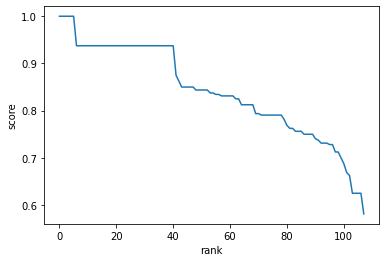

In [12]:
plt.plot(results.match_score.values)
plt.xlabel("rank")
plt.ylabel("score")

In [13]:
results.style.background_gradient(plt.get_cmap())

,match_score,canon_index,departamento,municipio
slug,,,,
santander-tibú,1.000000,54810,norte-de-santander,tibú
valle-del-cauca-padilla,1.000000,19513,cauca,padilla
santander-la-esperanza,1.000000,54385,norte-de-santander,la-esperanza
santander-el-carmen,1.000000,54245,norte-de-santander,el-carmen
valle-del-cauca-buenos-aires,1.000000,19110,cauca,buenos-aires
valle-del-cauca-caloto,1.000000,19142,cauca,caloto
antioquia-el-carmen,0.937500,05148,antioquia,el-carmen-de-viboral
santander-el-cerrito,0.937500,68162,santander,cerrito
tolima-armero-guayabal,0.937500,73055,tolima,armero


This results seem to be fine up to `"sucre-san-antonio"`

In [14]:
# drop the bad replacements
bad_results = results.loc["sucre-san-antonio":]
results = results.loc[:"sucre-san-antonio"]

In [15]:
bad_results

,match_score,canon_index,departamento,municipio
slug,,,,
sucre-san-antonio,0.71250,70678,sucre,san-benito-abad
magdalena-pueblo-nuevo,0.71250,47570,magdalena,puebloviejo
cundinamarca-el-retorno,0.70000,25260,cundinamarca,el-rosal
norte-de-santander-campamento,0.68750,54498,norte-de-santander,ocaña
atlántico-la-peña,0.66875,08372,atlántico,juan-de-acosta
tolima-moniquirá,0.66250,73443,tolima,san-sebastián-de-mariquita
valle-del-cauca-sonsón,0.62500,19693,cauca,san-sebastián
boyacá-túquerres,0.62500,15090,boyacá,berbeo
cesar-santa-lucía,0.62500,20032,cesar,astrea


### perform the correction on the dataset

In [16]:
replacements = pd.concat([
    pd.concat([
        geo.set_index("slug").loc[good_slugs].id,
        results.canon_index
    ]).rename("id"),
    locations_agrosavia
],axis=1).id.to_dict()

In [17]:
AGROSAVIA_df.slug = AGROSAVIA_df.slug.replace(replacements)
AGROSAVIA_df.rename(columns={"slug":"geo_id"},inplace=True)
print(len(AGROSAVIA_df),"rows in total")
AGROSAVIA_df.dropna(axis=0,subset="geo_id",inplace=True)
print(len(AGROSAVIA_df),"rows with a DIVPOLA DANE code")

46462 rows in total
46449 rows with a DIVPOLA DANE code


In [18]:
cross_id = geo.set_index("id").loc[AGROSAVIA_df.geo_id]

In [19]:
AGROSAVIA_df.set_index("geo_id",inplace=True)

In [20]:
AGROSAVIA_df.departamento = cross_id.departamento
AGROSAVIA_df.municipio = cross_id.municipio

In [21]:
AGROSAVIA_df.reset_index(inplace=True)

In [22]:
AGROSAVIA_df

,geo_id,id,departamento,municipio,cultivo,fertilizantes,ph,materia_organica,fosforo,azufre,...,drenaje_regular,riego_aspersión,riego_cañón,riego_goteo,riego_gravedad,riego_manguera,riego_microaspersión,riego_no_cuenta_con_riego,riego_no_indica,riego_por_inundación
0,25286,NaN,cundinamarca,funza,uchuva,no indica,5.66,9.706679206531621,5.622298591549295,4.345549738219895,...,0,0,0,0,0,0,0,0,1,0
1,25095,NaN,cundinamarca,bituima,citricos,no indica,8.08,3.417594935131467,7.570467605633801,6.832460732984293,...,0,0,0,0,0,0,0,1,0,0
2,25873,NaN,cundinamarca,villapinzón,pastos-brachiaria,no indica,5.87,2.3366585759845657,16.901171830985913,14.424083769633508,...,0,0,0,0,0,0,0,1,0,0
3,25873,NaN,cundinamarca,villapinzón,pastos-brachiaria,no indica,5.56,6.8537571503076125,32.07638309859154,9.581151832460733,...,0,0,0,0,0,0,0,1,0,0
4,11001,NaN,bogotá-d-c,bogotá-d-c,papa de año,"15-15-15, 18-18-18 y 10-30-10",4.87,16.041250728069084,64.19919999999999,5.523560209424084,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46444,73055,NaN,tolima,armero,neem,no indica,6.81,1.09,68.6,5.94,...,0,0,0,0,0,0,0,0,1,0
46445,15238,NaN,boyacá,duitama,hortalizas,no indica,7.16,0.96,43.82,15.46,...,0,0,0,0,0,0,0,0,1,0
46446,25718,NaN,cundinamarca,sasaima,citricos-limón,no indica,4.19,4.61,24.13,10.11,...,0,0,0,0,0,0,0,0,1,0
46447,73347,NaN,tolima,herveo,aguacate,no indica,5.73,6.41,5.34,10.25,...,0,0,0,0,0,0,0,0,1,0


In [88]:
AGROSAVIA_df.to_csv("data/suelos_geolocalizado.csv",index=False)

# IDEAM

In [41]:
IDEAM_df = pd.read_csv("data/estaciones_preprocesado.csv")

In [42]:
IDEAM_df["slug"] = dual_column_ID(IDEAM_df,"departamento","municipio")
# clean from non word characters
IDEAM_df.departamento = IDEAM_df.departamento.transform(slugify,allow_unicode=True)
IDEAM_df.municipio = IDEAM_df.municipio.transform(slugify,allow_unicode=True)

### Process department names first

In [43]:
IDEAM_deps = IDEAM_df[["departamento"]].drop_duplicates()
IDEAM_deps.index = IDEAM_deps.departamento

In [44]:
results_dep = fuzzy_canonicalize(
    IDEAM_deps,
    geo_deps,
    {"departamento":1},
    {"departamento":3}
)

In [45]:
replacements_dep = {k:v for k,v in results_dep.departamento.iteritems() if k!=v}
replacements_dep

{'bogotá': 'bogotá-d-c',
 'archipiélago-de-san-andres-providencia-y-santa-catalina': 'archipiélago-de-san-andrés-providencia-y-santa-catalina',
 'atlantico': 'atlántico',
 'vaupes': 'vaupés'}

In [46]:
IDEAM_df.departamento.replace(replacements_dep,inplace=True)
# redo the slug
IDEAM_df["slug"] = dual_column_ID(IDEAM_df,"departamento","municipio")

### Process the dep-mun pairs

For this one we do not separate the already-matching slugs. The computation time is higher, but replacing the codes after the matching is easy.

In [47]:
locations_IDEAM = IDEAM_df[["slug","departamento","municipio"]].drop_duplicates().set_index("slug")

In [48]:
results_IDEAM = fuzzy_scoped_canonicalize(
    queries=locations_IDEAM,
    canonical=geo.set_index("id"),
    on_column="departamento",
    scoping=search_by_dep,
    fuzzy_weights={"departamento":1,"municipio":2},
    exact_weights={"municipio":0.2}
)

100%|███████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.84it/s]


Text(0, 0.5, 'score')

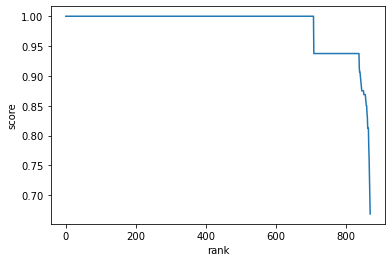

In [49]:
plt.plot(results_IDEAM.match_score.values)
plt.xlabel("rank")
plt.ylabel("score")

In [50]:
results_IDEAM.query("match_score != 1").style.background_gradient(plt.get_cmap())

,match_score,canon_index,departamento,municipio
slug,,,,
la-guajira-villanueva-la-guajira,0.937500,44874,la-guajira,villanueva
tolima-armero-guayabal,0.937500,73055,tolima,armero
antioquia-la-unión-antioquia,0.937500,05400,antioquia,la-unión
cauca-suárez-cauca,0.937500,19780,cauca,suárez
nariño-magüí-payán,0.937500,52427,nariño,magüí
cundinamarca-san-cayetano-cundinamarca,0.937500,25653,cundinamarca,san-cayetano
sucre-tolú,0.937500,70820,sucre,santiago-de-tolú
boyacá-miraflores-boyacá,0.937500,15104,boyacá,boyacá
cundinamarca-san-bernardo-cundinamarca,0.937500,25649,cundinamarca,san-bernardo


In [57]:
# put to NaN the bad replacements
results_IDEAM.at["amazonas-santander-araracuara","canon_index"] = float("NaN")
results_IDEAM.at["guainía-mapiripana","canon_index"] = float("NaN")

In [59]:
replacements_IDEAM = results_IDEAM.canon_index.sort_index().to_dict()

In [60]:
IDEAM_df.slug.replace(replacements_IDEAM,inplace=True)
IDEAM_df.rename(columns={"slug":"geo_id"},inplace=True)

In [66]:
IDEAM_df.dropna(inplace=True)

In [67]:
# verify all slugs are now geo_ids
IDEAM_df.geo_id.apply(len).value_counts()

5    869
Name: geo_id, dtype: int64

In [94]:
IDEAM_df[
    ["geo_id","departamento","municipio","altitud","latitud","longitud"]
].to_csv("data/estaciones_geolocalizado.csv",index=False)